In [81]:
%load_ext autoreload
%autoreload 2

from mair_tools import notebook_utils
import pandas as pd
import matplotlib
import pickle
import re
import os
import spacy
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
import spacy.lang.en
from collections import Counter
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()

PICKLED_PATH = "parserd_pdfs.pkl"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
if not os.path.exists(PICKLED_PATH):
    pdfs = notebook_utils.parse_all_files_from_path("../articles/FAT_20/")
    with open(PICKLED_PATH, "wb+") as f:
        pickle.dump(pdfs, f)
else:
    with open(PICKLED_PATH, "rb") as f:
        pdfs = pickle.load(f)

# Cleaning

In [3]:
df = pd.DataFrame(pdfs)
df['pages_num']=df.pages.str.len()

<AxesSubplot:>

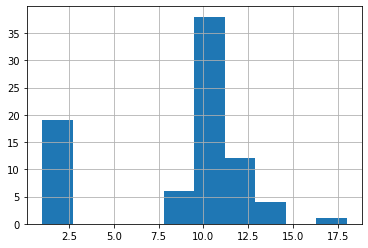

In [4]:
df.pages_num.hist()

### Removing papers with only one page

<AxesSubplot:>

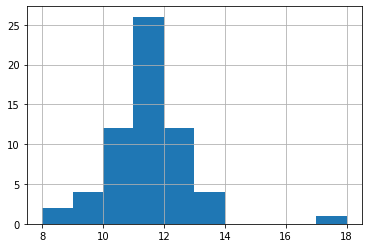

In [5]:
df=df[df.pages_num!=1]
df.pages_num.hist()

### Removing references and bibliography

In [6]:
def clean_text(text):
    # removing bibliography
    position = text.lower().rfind("references")
    text = text[:position]

    text = text.replace("\n", " ")  # removing newlines

    text = re.sub("\[[^\[^\]]*\]", "", text)  # removing references
    return text

In [7]:
df['cleaned_text']=df.full_text.apply(clean_text)

# Keywords

In [8]:
en=spacy.load('en_core_web_lg')

In [9]:
en = spacy.lang.en.English()

In [10]:
tokenized = df.cleaned_text.apply(lambda x: en(x))

In [89]:
lemmas = tokenized.apply(
    lambda doc: 
        [word.lemma_.lower() for word in doc if not word.is_stop if word.is_alpha])

In [91]:
all_lemas = []
for l in lemmas:
    all_lemas+=l

In [92]:
unigrams = nltk.FreqDist(all_lemas)

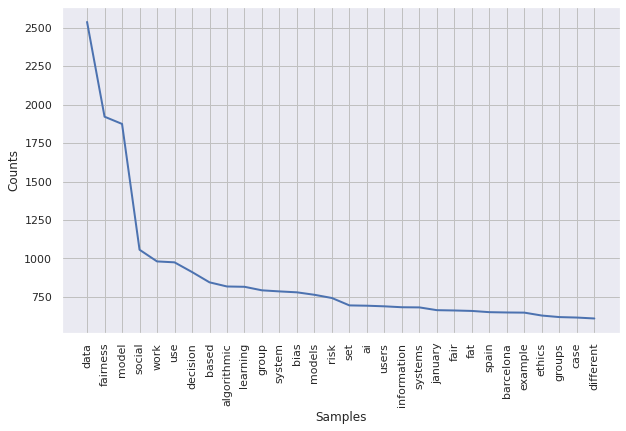

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [93]:
plt.figure(figsize=(10,6))

unigrams.plot(30)

## TFIDF

In [115]:
from gensim import corpora
from gensim import models


In [102]:
dictionary = corpora.Dictionary(lemmas)

In [105]:
bow_lemmas = lemmas.apply(dictionary.doc2bow)

In [112]:
tfidf = models.TfidfModel(list(bow_lemmas))

In [114]:
from gensim import similarities

index = similarities.SparseMatrixSimilarity(tfidf[bow_lemmas], num_features=12)

#TODO

## Keywords

In [134]:
import gensim.summarization

In [135]:
keywords = lemmas.apply(" ".join).apply(gensim.summarization.keywords).str.split('\n')

In [136]:
keywords

0     [model, models, predictive modeling, explanati...
2     [races, racialized, racial categories adopted,...
3     [patient, patients, evaluation sepsis watch, d...
4     [assessed, client vendor, employment assessmen...
5     [archiving, collections, collectively, activel...
                            ...                        
59    [tasks, models, modeling, methods, bias, task ...
60    [model, models, modeled, explaining, explain, ...
77    [image, imaging, imageable, imageability, syns...
78    [advertisement, bid, auctions, auctioneer, auc...
79    [targeted, target, targets, programs, country,...
Name: cleaned_text, Length: 61, dtype: object

In [138]:
all_keywords = []
for k in keywords:
    all_keywords+=k

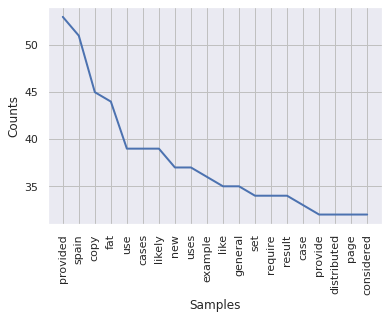

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [140]:
nltk.FreqDist(all_keywords).plot(20)